In [1]:
from matplotlib import pyplot as plt

from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.eeli import EELI

MINUTE = 60

Load a sequence from file.

In [2]:
sequence = load_eit_data("tests/test_data/Draeger_Test.bin", vendor="draeger")

Filter the global impedance using a low pass filter.

In [3]:
gi = sequence.continuous_data["global_impedance_(raw)"]

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].sample_frequency,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)

sequence.continuous_data.add(
    ContinuousData(
        "global_impedance_(lowpass)",
        "Global impedance (low pass filtered)",
        "a.u.",
        "impedance",
        derived_from=[*gi.derived_from, gi],
        parameters={LowPassFilter: filter_params},
        time=gi.time,
        values=filter_.apply_filter(gi.values),
        sample_frequency=gi.sample_frequency,
    ),
)

Select a small portion of the sequence.

In [4]:
sequence = sequence.t[56600:56650]

Determine the EELI of the selected portion.

In [5]:
cd = sequence.continuous_data["global_impedance_(raw)"]
cd_filtered = sequence.continuous_data["global_impedance_(lowpass)"]
eeli_result = EELI().compute_parameter(cd)
eeli_result_filtered = EELI().compute_parameter(cd_filtered)

Plot the results.

Note that the variation in the EELI has decreased after filtering the global impedance. The filter removed the high
frequency noise (mainly cardiac artifacts), which was causing the EELI to fluctuate. 

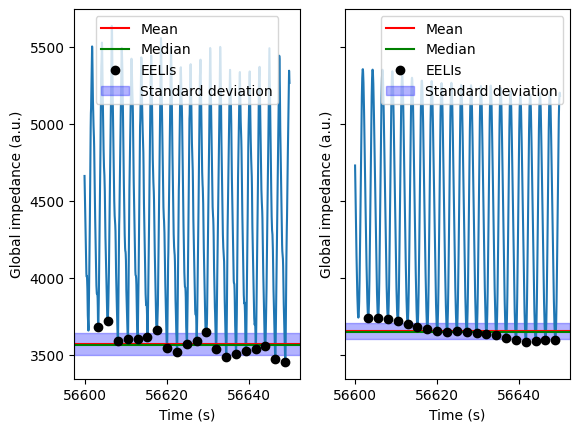

In [6]:
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
for ax, result, gi in zip(
    (ax1, ax2),
    (eeli_result, eeli_result_filtered),
    (
        sequence.continuous_data["global_impedance_(raw)"],
        sequence.continuous_data["global_impedance_(lowpass)"],
    ),
    strict=False,
):
    sd_upper = np.mean(result.values) + np.std(result.values)
    sd_lower = np.mean(result.values) - np.std(result.values)

    ax.plot(gi.time, gi.values)
    ax.axhline(np.mean(result.values), color="red", label="Mean")
    ax.axhline(np.median(result.values), color="green", label="Median")
    ax.plot(
        result.time,
        result,
        "o",
        color="black",
        label="EELIs",
    )

    xlim = ax.get_xlim()
    ax.fill_between(
        xlim,
        sd_upper,
        sd_lower,
        color="blue",
        alpha=0.3,
        label="Standard deviation",
    )
    ax.set(xlim=xlim, xlabel="Time (s)", ylabel="Global impedance (a.u.)")
    ax.legend()